In [1]:
import sys
sys.path.append("./source")

from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data Preparation

First of all, let's load the data to see what we have

In [2]:
# load data
with open('./data/cell_cycle.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    
data_array = data_dict['data']
time_points = data_dict['t']

In [3]:
df = pd.DataFrame(data_array.numpy()[0])
df.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df.head()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058


In [4]:
feature_list = [] # here we do not have external time-series
target_list = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']

# add time_points to df
df['Time'] = time_points
df.head()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Time
Strain,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761,0.2
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450,0.4
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087,0.6
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058,0.8


In [5]:
steady_state = df[df.Time > 500]
steady_state.shape

(4999, 8)

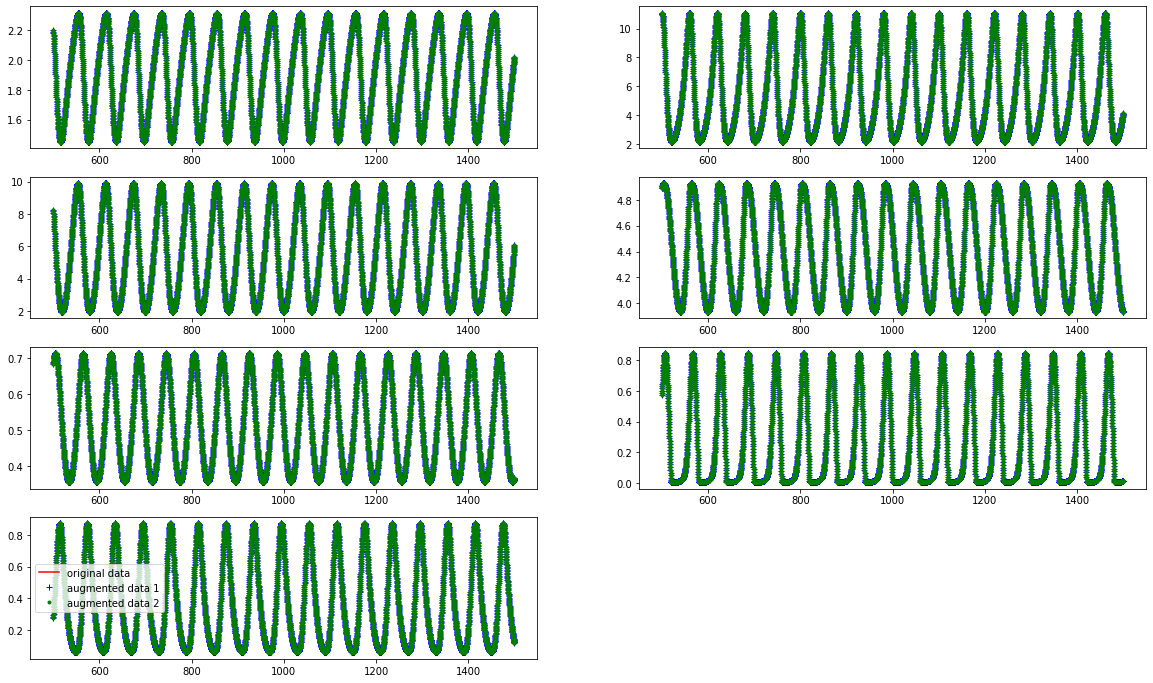

In [6]:
df_train1 = train_onestep.generate_dataset(steady_state, [0],feature_list, target_list, n_dim=5000)
df_train2 = train_onestep.generate_dataset(steady_state, [0],feature_list, target_list, n_dim=10000)

plt.figure(figsize = (20, 12))
for species in range(7):
    plt.subplot(4, 2, species + 1)
    plt.plot(steady_state.Time, steady_state.iloc[:,species], 'r-', label='original data')
    plt.plot(df_train1.index.get_level_values(1), df_train1[('feature', df.columns[species])], 'b+', label='augmented data 1')
    plt.plot(df_train2.index.get_level_values(1), df_train2[('feature', df.columns[species])], 'g.', label='augmented data 2')
    
plt.legend()

# 2. Training

In [7]:
# the features are the multi-dimensional time-series concentrations
# the target is the derivative of the dynamics
from sklearn.ensemble import RandomForestRegressor

# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)

cyclin


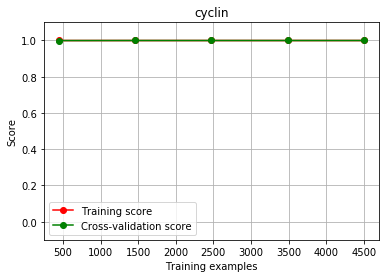

Target: cyclin, CV Pearson R2 coefficient: 0.999991
MPF


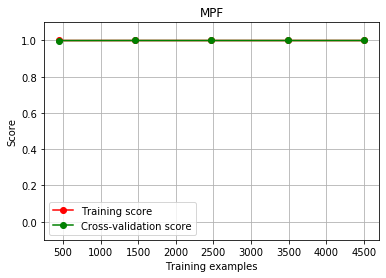

Target: MPF, CV Pearson R2 coefficient: 1.000000
preMPF


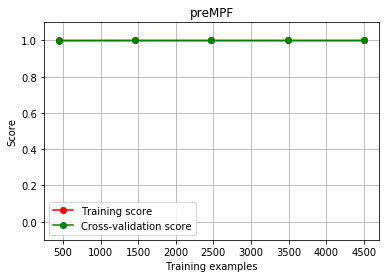

Target: preMPF, CV Pearson R2 coefficient: 1.000000
cdc25P


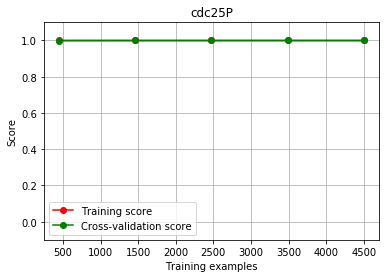

Target: cdc25P, CV Pearson R2 coefficient: 0.999994
wee1P


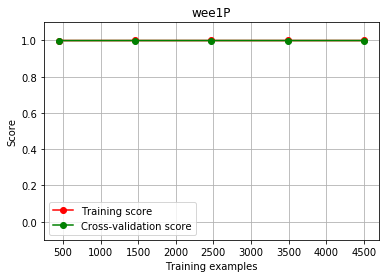

Target: wee1P, CV Pearson R2 coefficient: 0.999903
IEP


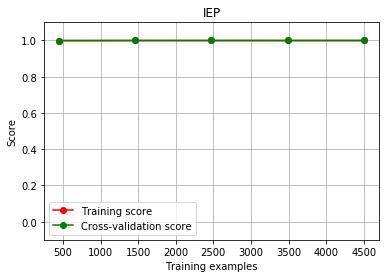

Target: IEP, CV Pearson R2 coefficient: 0.999993
APC


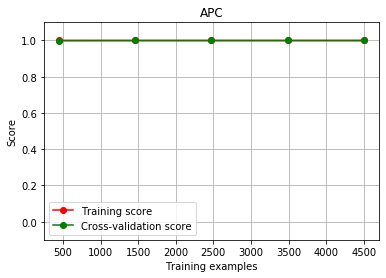

Target: APC, CV Pearson R2 coefficient: 0.999994
Average training score: 0.9999821335369726


In [8]:
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit

figure_path = './plots/'

# train a model
model_type = 'random_forest'
rf_dict1, score_dict1 = train_onestep.train_classic(df_train1, rf_model, plot=True,model_type=model_type, figure_path=figure_path)

cyclin


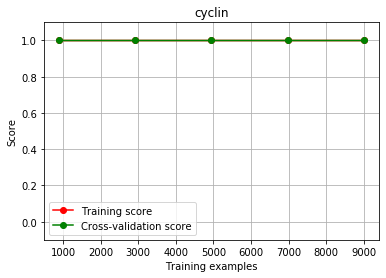

Target: cyclin, CV Pearson R2 coefficient: 0.999990
MPF


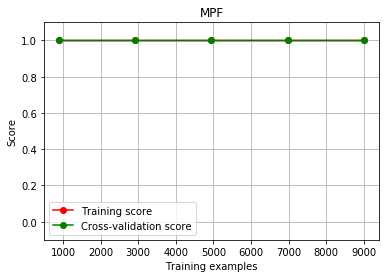

Target: MPF, CV Pearson R2 coefficient: 1.000000
preMPF


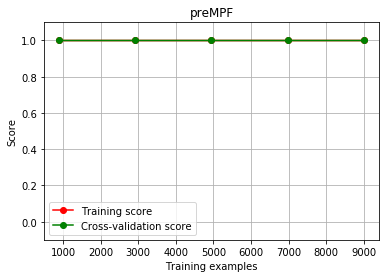

Target: preMPF, CV Pearson R2 coefficient: 1.000000
cdc25P


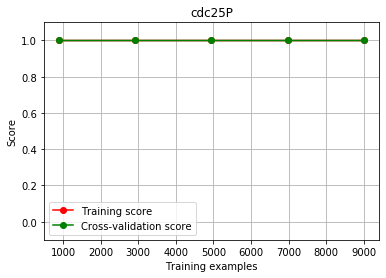

Target: cdc25P, CV Pearson R2 coefficient: 0.999995
wee1P


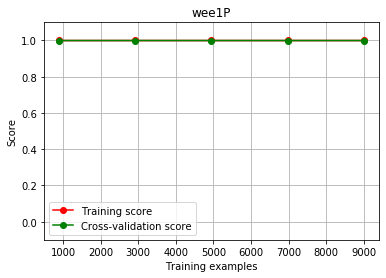

Target: wee1P, CV Pearson R2 coefficient: 0.999895
IEP


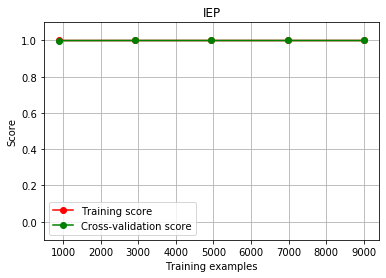

Target: IEP, CV Pearson R2 coefficient: 0.999993
APC


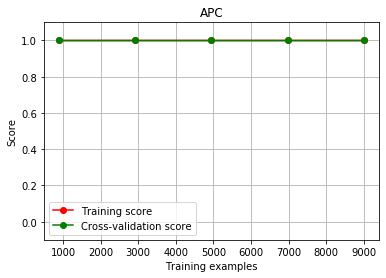

Target: APC, CV Pearson R2 coefficient: 0.999995
Average training score: 0.9999810264628802


In [9]:
rf_dict2, score_dict2 = train_onestep.train_classic(df_train2, rf_model, plot=True,model_type=model_type, figure_path=figure_path)

cyclin RMSE: 3.999329871696518e-07 standard deviation: 0.00010075089104212602


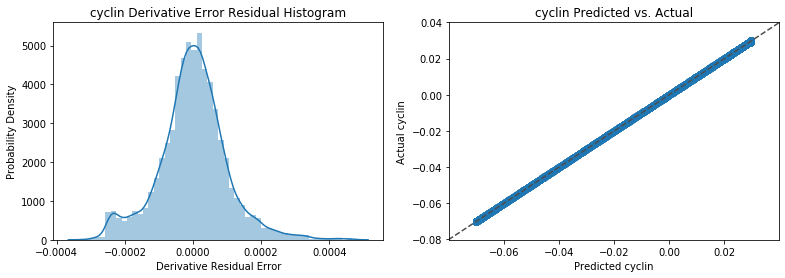

MPF RMSE: -6.322760831981132e-06 standard deviation: 0.00023978430556825908


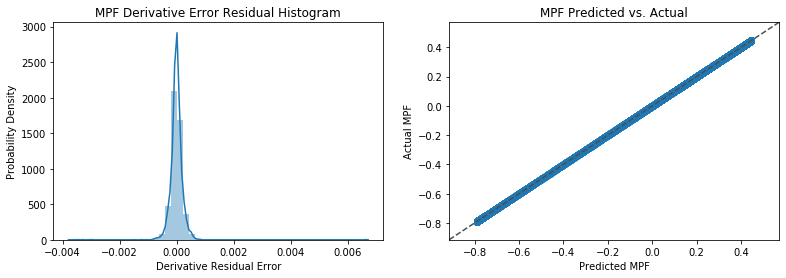

preMPF RMSE: 2.803078738489424e-06 standard deviation: 0.0001936195300338695


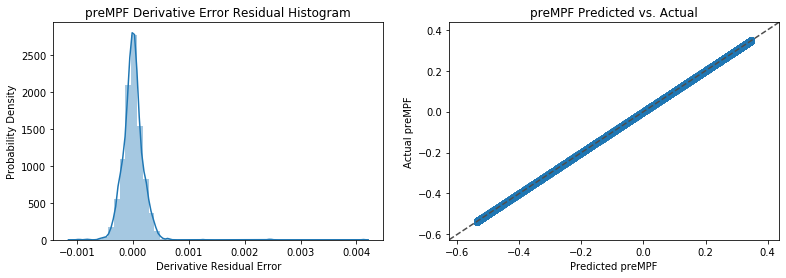

cdc25P RMSE: 1.0901870080868798e-06 standard deviation: 9.294012988947056e-05


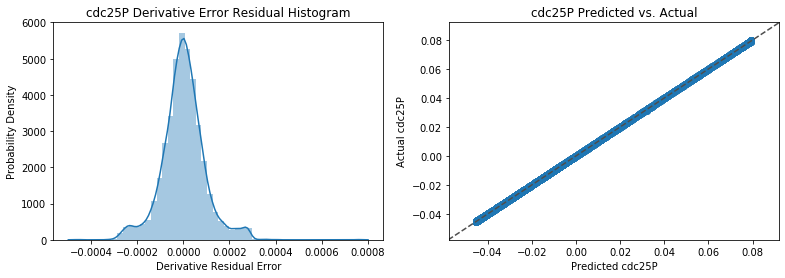

wee1P RMSE: 1.3871558487714257e-07 standard deviation: 0.00013129245433715414


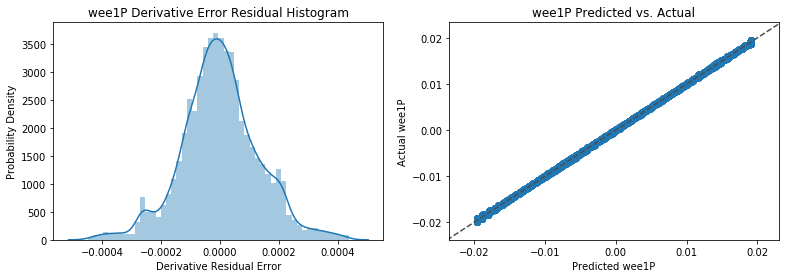

IEP RMSE: 3.8956943033876914e-07 standard deviation: 0.00011255056135678769


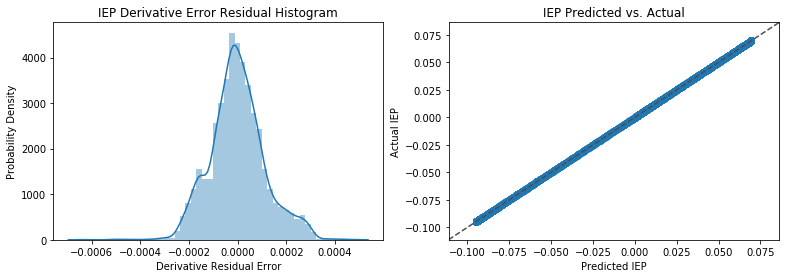

APC RMSE: -4.681539533797699e-08 standard deviation: 7.951013099308765e-05


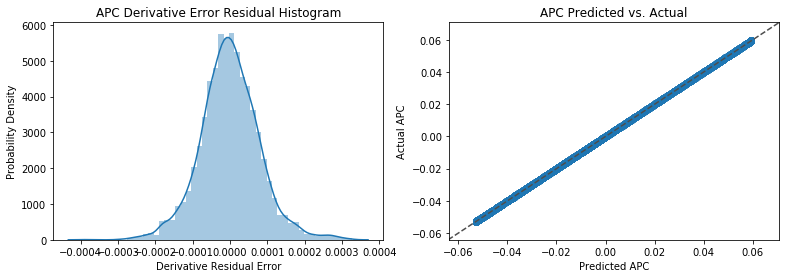

Total Derivative Mean Error: 0.8554868060700829 Error Standard Deviation: 0.015314091507577548


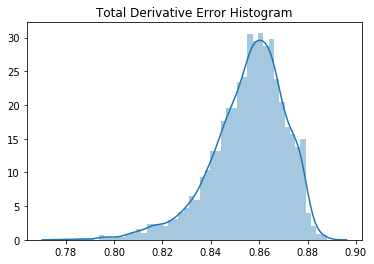

In [10]:
# compute the error
train_onestep.compute_error(df_train1,rf_dict1,plot=True,model_type=model_type)

cyclin RMSE: 7.813904805166327e-07 standard deviation: 0.00010696640428356758


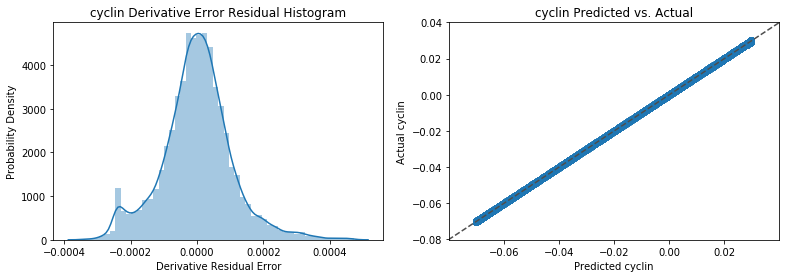

MPF RMSE: 1.5227374209681732e-07 standard deviation: 0.00012551491979698239


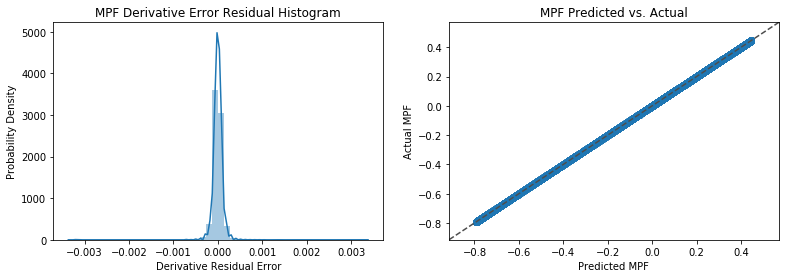

preMPF RMSE: 3.067677131156607e-06 standard deviation: 0.00012278037470136904


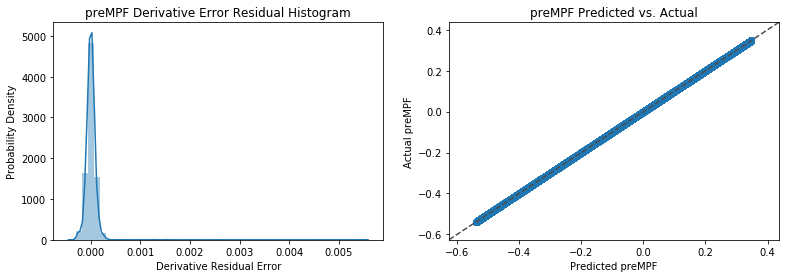

cdc25P RMSE: 5.704364483994653e-08 standard deviation: 8.327717940547161e-05


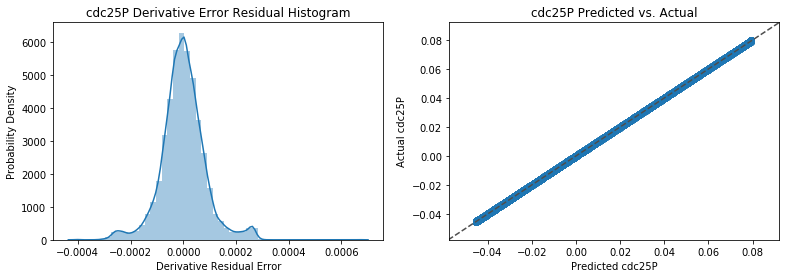

wee1P RMSE: 6.377072728099923e-07 standard deviation: 0.00013705479131576474


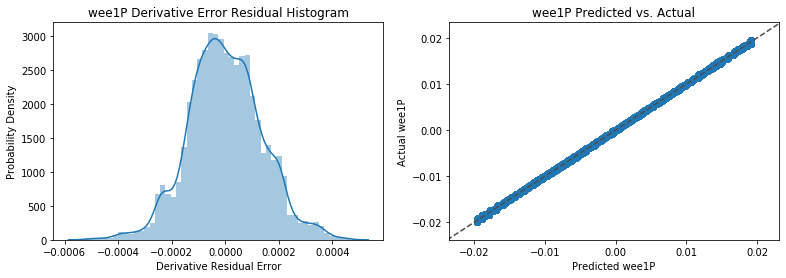

IEP RMSE: -1.4889661359642972e-06 standard deviation: 0.00011347193004380293


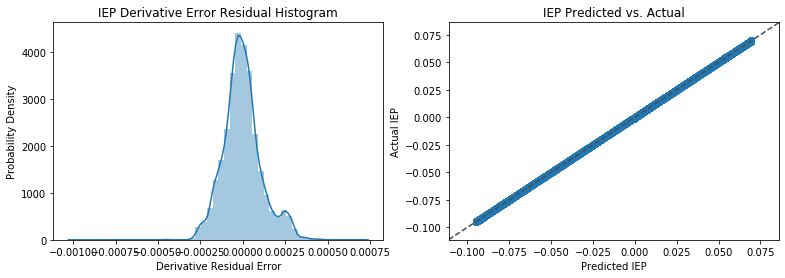

APC RMSE: -8.407522709881394e-07 standard deviation: 7.602182747907118e-05


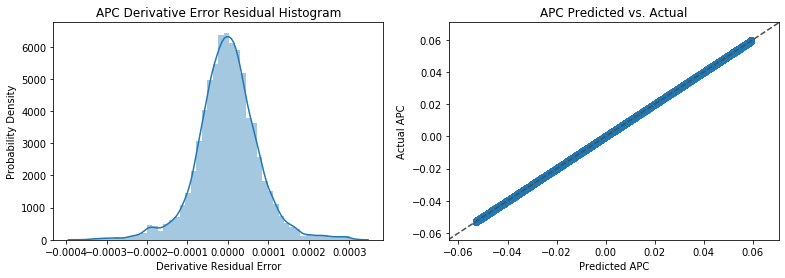

Total Derivative Mean Error: 0.8562319930436357 Error Standard Deviation: 0.01567510998965618


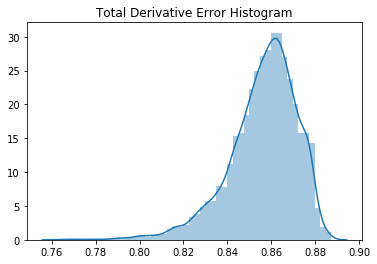

In [11]:
train_onestep.compute_error(df_train2,rf_dict2,plot=True,model_type=model_type)

Oscillating system -> derivative is also oscillating.
* Random Forest/ Decision tree will have a difficult time partitioning the feature space (features are correlated).
* Linear Regression / Polynomial Regression (works locally but not globally, true underlying distribution is trigonometric) -- this also includes having prior knowledge about the form of the governing equations
* Neural Network -- will have no problem approximating oscillating function with sigmoid (logistic) activation.

$$ y = f(x) + \epsilon$$
noise is zero and gaussian-like: distribution of the regressor is centered on the true target --> estimate is bias-free.

Real data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,2.197520,11.077987,8.270448,4.889503,0.683538,0.574962,0.274468
0,2.188358,11.064871,8.177385,4.895817,0.686023,0.588723,0.283716
0,2.178846,11.045707,8.082685,4.901462,0.688413,0.602374,0.293166
0,2.168990,11.020412,7.986447,4.906463,0.690706,0.615892,0.302813
0,2.158798,10.988926,7.888774,4.910855,0.692898,0.629251,0.312652
...,...,...,...,...,...,...,...
0,1.998806,3.987818,5.824301,3.937864,0.363066,0.010790,0.128617
0,2.003932,4.028746,5.892361,3.936569,0.363970,0.011015,0.125962
0,2.009037,4.070185,5.960643,3.935427,0.364922,0.011248,0.123366


Predicted data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Time,,,,,,,
500.2,2.197520,11.077987,8.270448,4.889503,0.683538,0.574962,0.274468
500.4,2.188343,11.064752,8.177426,4.895819,0.686040,0.588726,0.283727
500.6,2.178834,11.045587,8.082757,4.901496,0.688445,0.602372,0.293172
500.8,2.168974,11.020256,7.986507,4.906508,0.690763,0.615899,0.302819
501.0,2.158782,10.988636,7.888848,4.910891,0.692958,0.629268,0.312642
...,...,...,...,...,...,...,...
1499.0,1.465486,-297.752422,-62.698725,-23.360410,-7.825887,2.759919,-27.511475
1499.2,1.465394,-297.844156,-62.718659,-23.368998,-7.829814,2.760317,-27.520255
1499.4,1.465302,-297.935890,-62.738592,-23.377586,-7.833742,2.760715,-27.529036


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: cyclin 11.714622373407265 RMSE percentage: 30.485777185678653


./source/predict_onestep.py:222: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: MPF 4509.46836924237 RMSE percentage: 405.6294146903632
ML Fit: preMPF 1034.858112935797 RMSE percentage: 195.00992467637138
ML Fit: cdc25P 410.0986553175581 RMSE percentage: 117.90270391894504
ML Fit: wee1P 107.61518397643404 RMSE percentage: 175.80618387499675
ML Fit: IEP 49.82993846787974 RMSE percentage: 819.6864881558308
ML Fit: APC 406.6754858007319 RMSE percentage: 583.4230408233533
ML model aggregate error
Average RMSE: 932.8943383020253
Total percentage error: 332.56336190364846


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


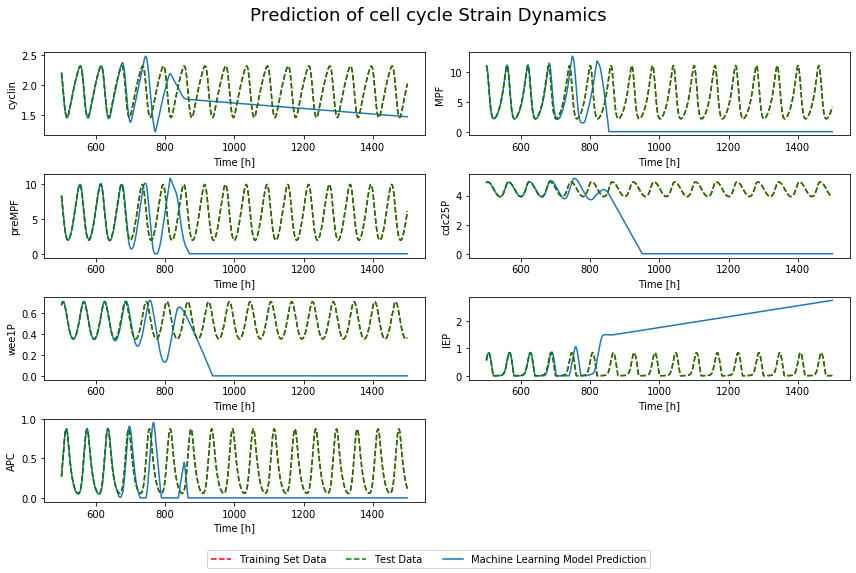

In [12]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe

time_points, predictions = predict_onestep.predict_integrate(steady_state, steady_state, rf_dict1, target_list, feature_list, title='cell cycle', plot=True,model_type=model_type, subplots=(4,2))

Real data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,2.197520,11.077987,8.270448,4.889503,0.683538,0.574962,0.274468
0,2.188358,11.064871,8.177385,4.895817,0.686023,0.588723,0.283716
0,2.178846,11.045707,8.082685,4.901462,0.688413,0.602374,0.293166
0,2.168990,11.020412,7.986447,4.906463,0.690706,0.615892,0.302813
0,2.158798,10.988926,7.888774,4.910855,0.692898,0.629251,0.312652
...,...,...,...,...,...,...,...
0,1.998806,3.987818,5.824301,3.937864,0.363066,0.010790,0.128617
0,2.003932,4.028746,5.892361,3.936569,0.363970,0.011015,0.125962
0,2.009037,4.070185,5.960643,3.935427,0.364922,0.011248,0.123366


Predicted data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Time,,,,,,,
500.2,2.197520,11.077987,8.270448,4.889503,0.683538,0.574962,0.274468
500.4,2.188352,11.064871,8.177395,4.895846,0.686033,0.588753,0.283719
500.6,2.178846,11.045702,8.082721,4.901517,0.688439,0.602402,0.293175
500.8,2.168985,11.020381,7.986476,4.906529,0.690758,0.615924,0.302820
501.0,2.158793,10.988919,7.888823,4.910934,0.692949,0.629294,0.312654
...,...,...,...,...,...,...,...
1499.0,1.200112,-272.226593,-54.288442,-18.221983,-10.971975,2.238420,-25.631891
1499.2,1.200485,-272.322334,-54.309138,-18.230272,-10.975911,2.238571,-25.640820
1499.4,1.200858,-272.418074,-54.329833,-18.238560,-10.979847,2.238723,-25.649749


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: cyclin 31.69702219638279 RMSE percentage: 52.60038849061372


./source/predict_onestep.py:222: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: MPF 3870.830431664732 RMSE percentage: 365.06660708844595
ML Fit: preMPF 835.8961509553419 RMSE percentage: 169.69249179549405
ML Fit: cdc25P 306.225400971218 RMSE percentage: 98.03340008701021
ML Fit: wee1P 160.55929399330688 RMSE percentage: 216.21462226023036
ML Fit: IEP 44.31574944280725 RMSE percentage: 762.6970795539163
ML Fit: APC 363.28558951233117 RMSE percentage: 538.3796223204259
ML model aggregate error
Average RMSE: 801.8299483908742
Total percentage error: 314.66917308516236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


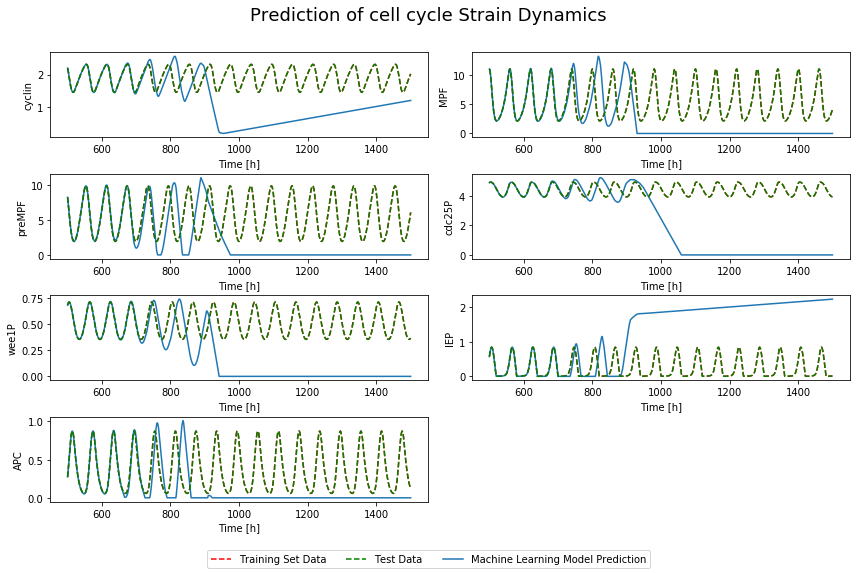

In [13]:
time_points, predictions = predict_onestep.predict_integrate(steady_state, steady_state, rf_dict2, target_list, feature_list, title='cell cycle', plot=True,model_type=model_type, subplots=(4,2))